**Temat:** Analiza sentymentu w tekstach internetowych w oparciu o sieci typu Transformer

**Wprowadzenie:** Analiza sentymentu to technika przetwarzania języka naturalnego (NLP), która identyfikuje ton emocjonalny w tekście, klasyfikując go na pozytywny, negatywny lub neutralny. Wykorzystuje się ją do badania opinii klientów, monitorowania reputacji marki czy analizy treści mediów społecznościowych.

**Cel projektu:** Celem projektu jest opracowanie i implementacja modelu analizy sentymentu, który pozwoli na klasyfikację opinii użytkowników na podstawie tekstów pochodzących z Internetu. Należy przeanalizować dane tekstowe, przygotować odpowiedni model oraz zaprezentować wyniki analizy.

### Konfiguracja środowiska 

In [1]:
%pip install datasets transformers torch langdetect scikit-learn seaborn pandas matplotlib wordcloud nltk spacy jieba --quiet

Note: you may need to restart the kernel to use updated packages.


### Ładowanie danych

In [1]:
from datasets import load_dataset

ds = load_dataset("clapAI/MultiLingualSentiment")

/Users/michalklos/Studia_Projekty/NLP/Multilingual-sentiment-analysis/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'source', 'domain', 'language'],
        num_rows: 3147478
    })
    validation: Dataset({
        features: ['text', 'label', 'source', 'domain', 'language'],
        num_rows: 393435
    })
    test: Dataset({
        features: ['text', 'label', 'source', 'domain', 'language'],
        num_rows: 393436
    })
})


### Redukcja datasetów, wymieszanie rekordów oraz podział na język + typ zbioru

In [3]:
languages = ds['train'].unique('language')
ds_types = ['train', 'validation', 'test']
drop_columns = ['source', 'domain']
languages_to_process = ['en', 'es', 'zh']
ds = ds.remove_columns(drop_columns)
# Create dictionary to store datasets for each language
datasets = {}

# Split train, validation and test for each language
for lang in languages_to_process:
    datasets[lang] = {}
    for ds_type in ds_types:
        datasets[lang][ds_type] = ds[ds_type].filter(
            lambda batch: [x == lang for x in batch['language']],
            batched = True,
            num_proc=4
            )
        
        # Reduce dataset by 100 times
        rows_counter = datasets[lang][ds_type].num_rows
        new_num_rows = round(rows_counter*0.01)
        datasets[lang][ds_type] = datasets[lang][ds_type].shuffle(seed=42)
        datasets[lang][ds_type] = datasets[lang][ds_type].select(range(new_num_rows))

### Czyszczenie datasetów z błędnych języków

W zbiorze angielskim występowały próbki niechcianych języków np. turecki

In [ ]:
from langdetect import detect
import copy

dataset_copy = copy.deepcopy(datasets)

def detect_language(text):
    try:
        detected = detect(text)
        if detected.startswith('zh'):
            return 'zh'
        elif detected == 'es':
            return 'es'
        elif detected == 'en':
            return 'en'
        return detected
    except:
        return "unknown"
    
for ds_type in ds_types:
        for lang in languages_to_process:
            datasets[lang][ds_type] = datasets[lang][ds_type].filter(
                lambda batch: [detect_language(x) == lang for x in batch['text']],
                batched=True,
                num_proc=4
            )

{'en': {'train': Dataset({
    features: ['text', 'label', 'language'],
    num_rows: 10268
}), 'validation': Dataset({
    features: ['text', 'label', 'language'],
    num_rows: 1303
}), 'test': Dataset({
    features: ['text', 'label', 'language'],
    num_rows: 1276
})}, 'es': {'train': Dataset({
    features: ['text', 'label', 'language'],
    num_rows: 1749
}), 'validation': Dataset({
    features: ['text', 'label', 'language'],
    num_rows: 219
}), 'test': Dataset({
    features: ['text', 'label', 'language'],
    num_rows: 220
})}, 'zh': {'train': Dataset({
    features: ['text', 'label', 'language'],
    num_rows: 3148
}), 'validation': Dataset({
    features: ['text', 'label', 'language'],
    num_rows: 395
}), 'test': Dataset({
    features: ['text', 'label', 'language'],
    num_rows: 380
})}}


Filter (num_proc=4): 100%|██████████| 380/380 [00:00<00:00, 505.33 examples/s]


In [12]:
# calculate how many rows were removed
for lang in languages_to_process:
    for ds_type in ds_types:
        original_rows = dataset_copy[lang][ds_type].num_rows
        filtered_rows = datasets[lang][ds_type].num_rows
        print(f"Language: {lang}, Dataset Type: {ds_type}, Original Rows: {original_rows}, Filtered Rows: {filtered_rows}")

print(datasets['en']['train'][0])
print(datasets['zh']['train'][0])
print(datasets['es']['train'][0])

Language: en, Dataset Type: train, Original Rows: 10268, Filtered Rows: 10260
Language: en, Dataset Type: validation, Original Rows: 1303, Filtered Rows: 1303
Language: en, Dataset Type: test, Original Rows: 1276, Filtered Rows: 1275
Language: es, Dataset Type: train, Original Rows: 1749, Filtered Rows: 1748
Language: es, Dataset Type: validation, Original Rows: 219, Filtered Rows: 219
Language: es, Dataset Type: test, Original Rows: 220, Filtered Rows: 220
Language: zh, Dataset Type: train, Original Rows: 3148, Filtered Rows: 3129
Language: zh, Dataset Type: validation, Original Rows: 395, Filtered Rows: 393
Language: zh, Dataset Type: test, Original Rows: 380, Filtered Rows: 379
{'text': 'Not allowed to withdraw my funds, and was told I can only cash out if I deactivate or close the account. Well if u say so.', 'label': 'negative', 'language': 'en'}
{'text': '妈妈说非常好，谢谢店家，会继续支持', 'label': 'positive', 'language': 'zh'}
{'text': 'Cada vez que como termino yendo al baño a hacer deposicio

### Przygotowanie datasetów z wybranymi językami

W ramach naszego usecase'u wybraliśmy 3 języki - angielski, hiszpański oraz chiński. Do rekordów dodaliśmy label_id jako wartość predykcyjna do uczenia.

In [13]:
from datasets import concatenate_datasets

labels_id = {'negative': 0, 'neutral': 1, 'positive': 2}

# Convert labels to IDs
def convert_labels_to_ids(batch):
    batch['label_id'] = [labels_id[label] for label in batch['label']]
    return batch

# train ds
train_ds_list = [datasets[lang]['train'] for lang in languages_to_process]
# Concatenate datasets for selected languages
train_ds = concatenate_datasets(train_ds_list)
train_ds = train_ds.map(convert_labels_to_ids, batched=True, num_proc=4)
train_ds = train_ds.shuffle(seed=42)

# eval ds
eval_ds_list = [datasets[lang]['validation'] for lang in languages_to_process]
# Concatenate datasets for selected languages
eval_ds = concatenate_datasets(eval_ds_list)
eval_ds = eval_ds.map(convert_labels_to_ids, batched=True, num_proc=4)
eval_ds = eval_ds.shuffle(seed=42)

# test ds
test_ds_list = [datasets[lang]['test'] for lang in languages_to_process]
# Concatenate datasets for selected languages
test_ds = concatenate_datasets(test_ds_list)
test_ds = test_ds.map(convert_labels_to_ids, batched=True, num_proc=4)
test_ds = test_ds.shuffle(seed=42)

Map (num_proc=4): 100%|██████████| 1874/1874 [00:00<00:00, 2426.78 examples/s]


In [14]:
print(train_ds[1])

{'text': "oh waffle house gods in the sky. thank you for arranging the stars so the good egg had a wait. i know your feelings may have been hurt because a certain someone didn't have her heart set on partaking in a meal at your restaurant. \\n\\nbut i love you, even though the tables are gnarly, the silverware is kinda clean, the floor is not to be made eye contact with and it is advisable to drink your beverage with a straw. and we with the help from the wait gods got three more waffle house converts out of a meal. \\n\\nour server was fantastic. she apologized because they were short staffed yet she was accommodating in every way. she exceeded all of our waffle house expectations. we had a little bit of everything and you can't go wrong with anything. get the hash browns all the way - it's a style, not a request. the burgers are good diner burgers too. \\n\\ny'all it's not a high class place. it's cheesy greasy, tasty and cheap. but it's f*(king delicious! and CA needs to get one.", 

### Eksploracja zbioru treningowego

Jak mozna zauwazyć niestety w zbiorach dane nie są równo rozłozone między wszystkie języki i etykiety, ale to nie stanowi dla nas problemu w trenowaniu modelu.

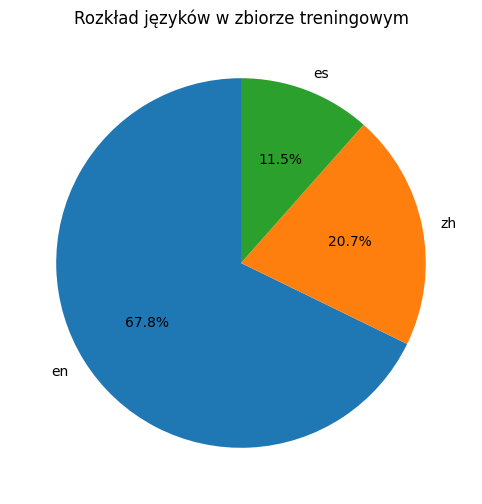

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

train_pd = train_ds.to_pandas()
language_stats = train_pd['language'].value_counts().reset_index()
language_stats.columns = ['language', 'count']
plt.figure(figsize=(10, 6))
plt.pie(language_stats['count'], labels=language_stats['language'], autopct='%1.1f%%', startangle=90)
plt.title('Rozkład języków w zbiorze treningowym')

plt.savefig('images/language_distribution_train.png', dpi=300, bbox_inches='tight')

plt.show()

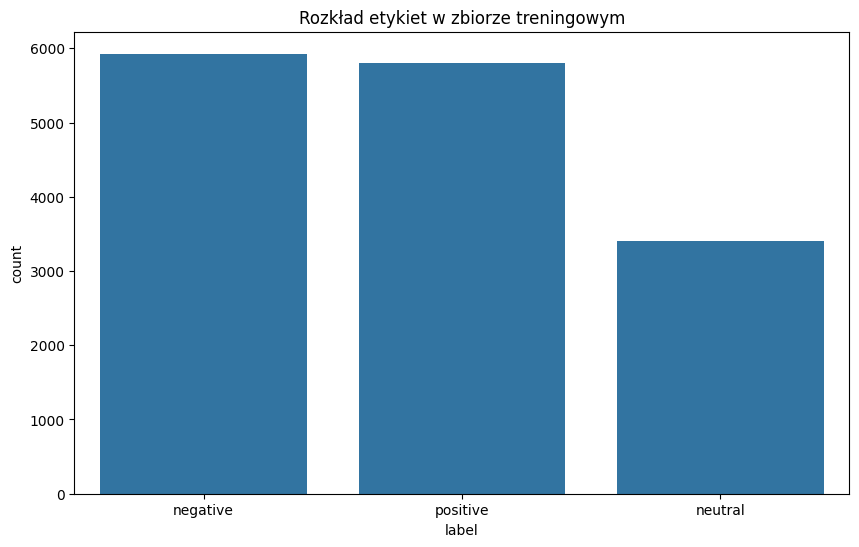

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

train_pd = train_ds.to_pandas()
label_stats = train_pd['label'].value_counts().reset_index()
label_stats.columns = ['label', 'count']
plt.figure(figsize=(10, 6))
sns.barplot(data=label_stats, x='label', y='count')
plt.title('Rozkład etykiet w zbiorze treningowym')

plt.savefig('images/label_distribution_train.png', dpi=300, bbox_inches='tight')

plt.show()

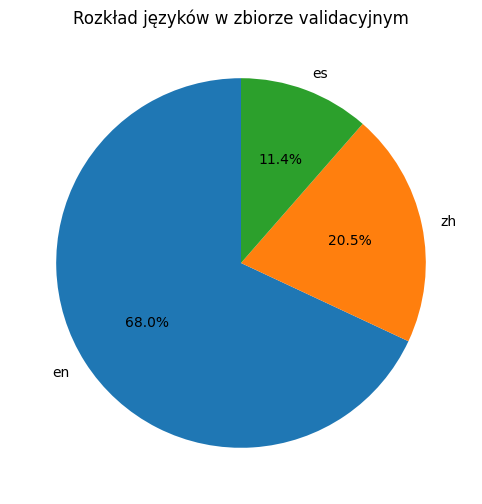

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

eval_pd = eval_ds.to_pandas()
language_stats = eval_pd['language'].value_counts().reset_index()
language_stats.columns = ['language', 'count']
plt.figure(figsize=(10, 6))
plt.pie(language_stats['count'], labels=language_stats['language'], autopct='%1.1f%%', startangle=90)
plt.title('Rozkład języków w zbiorze validacyjnym')

plt.savefig('images/language_distribution_eval.png', dpi=300, bbox_inches='tight')

plt.show()

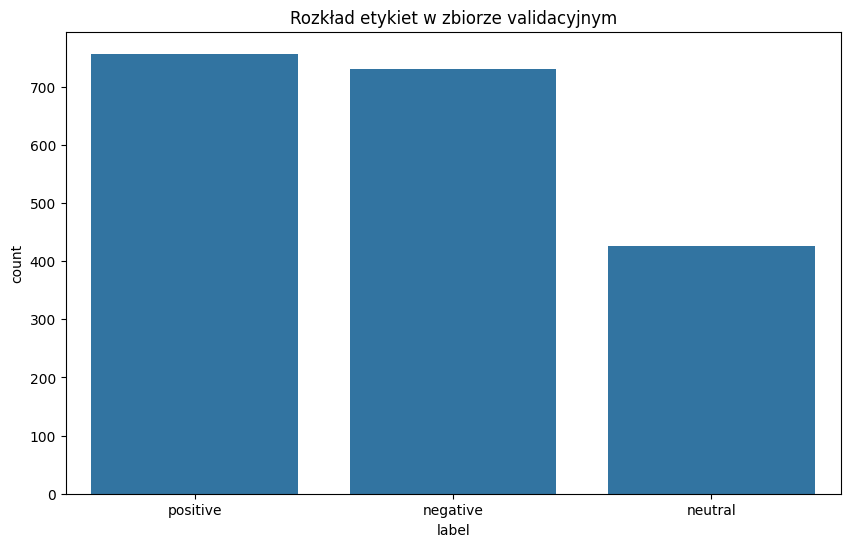

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

eval_pd = eval_ds.to_pandas()
label_stats = eval_pd['label'].value_counts().reset_index()
label_stats.columns = ['label', 'count']
plt.figure(figsize=(10, 6))
sns.barplot(data=label_stats, x='label', y='count')
plt.title('Rozkład etykiet w zbiorze validacyjnym')

plt.savefig('images/label_distribution_eval.png', dpi=300, bbox_inches='tight')

plt.show()

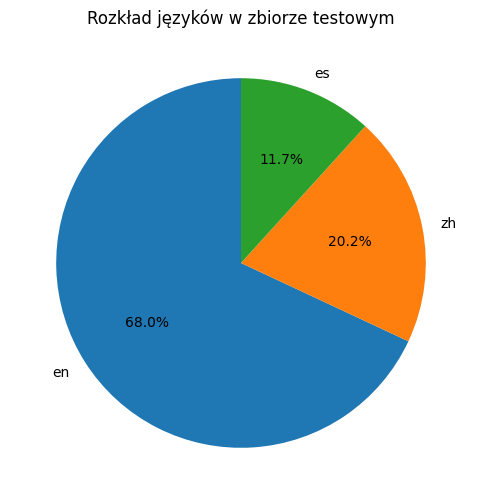

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

test_pd = test_ds.to_pandas()
language_stats = test_pd['language'].value_counts().reset_index()
language_stats.columns = ['language', 'count']
plt.figure(figsize=(10, 6))
plt.pie(language_stats['count'], labels=language_stats['language'], autopct='%1.1f%%', startangle=90)
plt.title('Rozkład języków w zbiorze testowym')

plt.savefig('images/language_distribution_test.png', dpi=300, bbox_inches='tight')

plt.show()

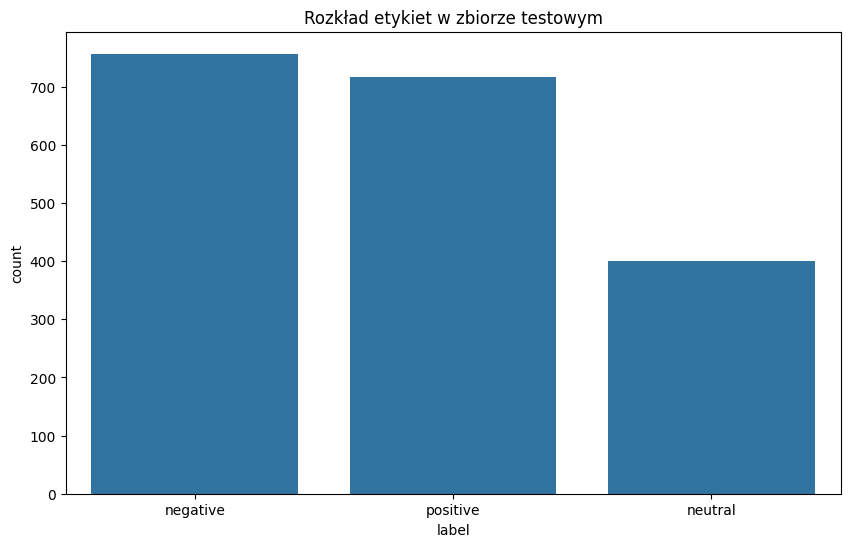

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

test_pd = test_ds.to_pandas()
label_stats = test_pd['label'].value_counts().reset_index()
label_stats.columns = ['label', 'count']
plt.figure(figsize=(10, 6))
sns.barplot(data=label_stats, x='label', y='count')
plt.title('Rozkład etykiet w zbiorze testowym')

plt.savefig('images/label_distribution_test.png', dpi=300, bbox_inches='tight')

plt.show()

### Wordclouds

In [21]:
import re
import nltk
import spacy
import jieba
from nltk.corpus import stopwords

Opcjonalne: przy problemach nltk z SSL:

In [16]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [22]:
import spacy.cli
spacy.cli.download("en_core_web_sm")
spacy.cli.download("es_core_news_sm")
spacy.cli.download("zh_core_web_sm")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 13.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 9.8 MB/s eta 0:00:00ta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 MB 27.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('zh_core_web_sm')


In [23]:
nltk.download('stopwords')

# Initialize spacy models
nlp_models = {
    'en': spacy.load('en_core_web_sm'),
    'es': spacy.load('es_core_news_sm'),
    'zh': spacy.load('zh_core_web_sm')
}

# Get stopwords
stop_words = {
    'en': set(stopwords.words('english')),
    'es': set(stopwords.words('spanish')),
    'zh': set()  # Chinese doesn't use stopwords
}

additional_spanish_stops = {
    'el', 'la', 'los', 'las', 'un', 'una', 'unos', 'unas',
    'lo', 'al', 'del', 'este', 'esta', 'estos', 'estas',
    'ese', 'esa', 'esos', 'esas', 'aquel', 'aquella',
    'muy', 'mucho', 'muchos', 'muchas', 'más', 'menos'
}
stop_words['es'].update(additional_spanish_stops)

print(stop_words['es'])

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>


{'ti', 'hayamos', 'habían', 'estarías', 'estaremos', 'una', 'tenga', 'hubieras', 'hubiéramos', 'tenidas', 'estaría', 'tendrás', 'con', 'fueseis', 'otros', 'tuve', 'nuestros', 'todos', 'éramos', 'estabas', 'mucho', 'nosotros', 'tened', 'contra', 'hayáis', 'seré', 'hubieseis', 'seáis', 'estéis', 'muy', 'ellas', 'estamos', 'estar', 'estad', 'del', 'al', 'algo', 'estuvo', 'tiene', 'estuviese', 'sentidas', 'tuyos', 'erais', 'estada', 'habéis', 'me', 'tu', 'entre', 'seamos', 'tengas', 'estés', 'sois', 'estuvierais', 'tuvieseis', 'nuestra', 'estuvieras', 'hubiste', 'tuviesen', 'han', 'e', 'hasta', 'habidas', 'los', 'vuestros', 'tenía', 'porque', 'tuvierais', 'tengáis', 'fuisteis', 'para', 'fuiste', 'estaríamos', 'haya', 'por', 'mis', 'hubieron', 'hubiesen', 'estuvieseis', 'estaba', 'estoy', 'esté', 'hubiese', 'cuando', 'nosotras', 'aquel', 'suya', 'sin', 'son', 'nuestras', 'esa', 'tendríamos', 'tenemos', 'estuvieran', 'seremos', 'ese', 'nuestro', 'tuyo', 'estáis', 'vosotras', 'tuya', 'sea', '

In [24]:
def remove_special_and_digits(txt, lang):
    # Remove special characters but keep Spanish-specific characters
    if lang == 'es':
        txt = re.sub(r'[^a-záéíóúüñA-ZÁÉÍÓÚÜÑ\s]', '', txt)
    else:
        txt = re.sub(r'[^a-zA-Z\u4e00-\u9fff\s]', '', txt)

    if lang == 'zh':
        txt = " ".join(jieba.cut(txt))

    if lang != 'zh':
        txt = txt.lower()
    
    document = nlp_models[lang](txt)

    tokens = []
    if lang == 'zh':
        tokens = [token.text for token in document if 
                (not token.is_stop and not token.is_space and
                len(token.text.strip()) > 0)]
    else:
        for token in document:
            # More aggressive stopword filtering for Spanish
            if lang == 'es':
                if (token.text.lower() not in stop_words['es'] and 
                    not token.is_space and 
                    len(token.text.strip()) > 0 and
                    not token.is_punct and
                    not token.like_num):
                    tokens.append(token.lemma_)
            else:
                if (token.text not in stop_words.get(lang, set()) and 
                    not token.is_space and 
                    len(token.text.strip()) > 0):
                    tokens.append(token.lemma_)
    
    return ' '.join(tokens)

def preprocess_dataset(example):
    example['preprocessed_text'] = remove_special_and_digits(
        example['text'], 
        example['language']
    )

    return example

In [25]:
print(train_ds)

preprocessed_dataset = train_ds.map(
    preprocess_dataset,
    num_proc=4, 
    batch_size=100
)

print("Original text:", preprocessed_dataset[0]['text'])
print("Preprocessed text:", preprocessed_dataset[0]['preprocessed_text'])

Dataset({
    features: ['text', 'label', 'language', 'label_id'],
    num_rows: 15137
})


Map (num_proc=4):   0%|          | 0/15137 [00:00<?, ? examples/s]Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/2f/ljz1r9416b1fr4bg0p4bd8p00000gn/T/jieba.cache
Map (num_proc=4):   0%|          | 1/15137 [00:00<35:31,  7.10 examples/s]Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/2f/ljz1r9416b1fr4bg0p4bd8p00000gn/T/jieba.cache
Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/2f/ljz1r9416b1fr4bg0p4bd8p00000gn/T/jieba.cache
Map (num_proc=4):   0%|          | 11/15137 [00:00<08:42, 28.96 examples/s]Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/2f/ljz1r9416b1fr4bg0p4bd8p00000gn/T/jieba.cache
Loading model cost 0.997 seconds.
Loading model cost 1.123 seconds.
Loading model cost 1.044 seconds.
Prefix dict has been built successfully.
Prefix dict has been built successfully.
Prefix dict has been built successfully.
Load

Original text: Gran cámara espía.
Me encanta que esta cámara se parezca a un reloj normal. Nadie sospecha que hay una cámara adentro. La cámara ofrece una excelente imagen y no tuve ningún problema para conectarla a la aplicación. Puedo ver las cosas en mi casa desde cualquier lugar con una imagen bonita y clara. Me encanta.
Preprocessed text: gran cámara espía encantar cámara parecer reloj normal nadie sospechar cámara adentro cámara ofrecer excelente imagen ninguno problema conectar él aplicación poder ver cosa casa cualquiera lugar imagen bonito claro encantar


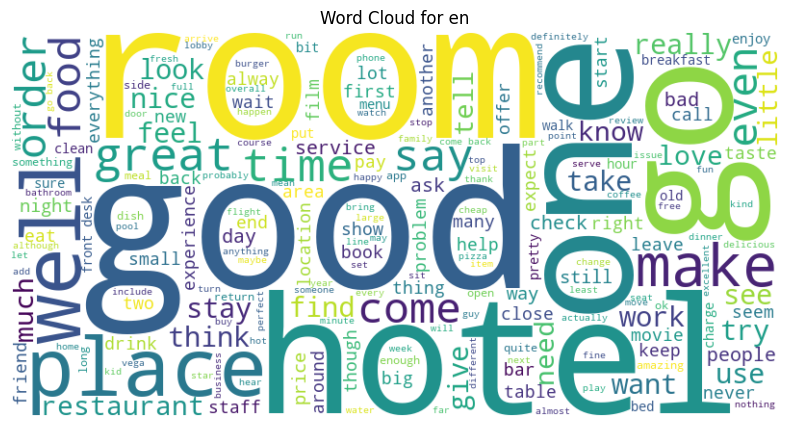

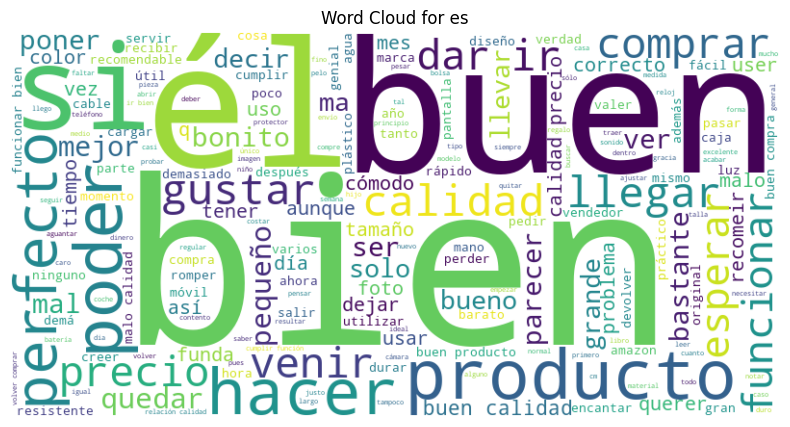

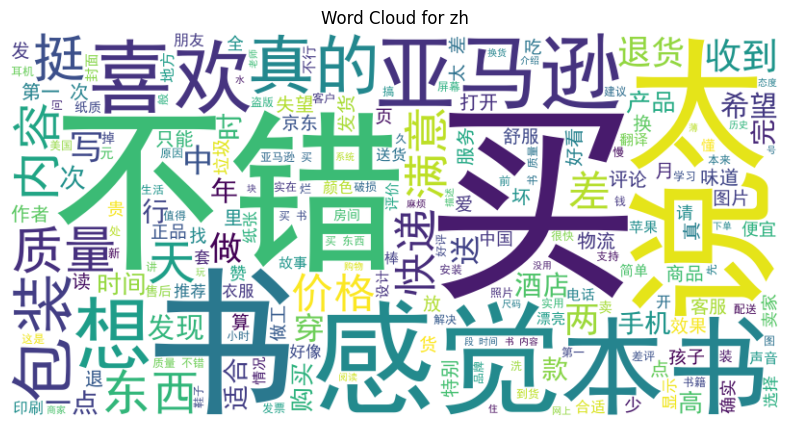

In [27]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

font_path = './resources/simhei.ttf'  # Path to a Chinese font file for word cloud

# Create word cloud for each language
for lang in languages_to_process:
    # Filter dataset by language
    lang_texts = ' '.join(preprocessed_dataset.filter(
        lambda x: x['language'] == lang
    )['preprocessed_text'])
    
    # Create and display word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        font_path=font_path if lang == 'zh' else None,  # Use Chinese font for Chinese text
    ).generate(lang_texts)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {lang}')
    plt.show()

    wordcloud.to_file(f'./wordclouds/wordcloud_{lang}.png')  # Save word cloud to file

### Tokenizacja

W ramach tego etapu załadowaliśmy juz wstępnie wytrenowany model i tokenizator z bert-base-multilingual-cased i dokonaliśmy tokenizacji zbioru treningowego i validacyjnego

In [38]:
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)

def tokenize_and_encode(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128,  # BERT max sequence length
        # return_tensors=None,  # Returns PyTorch tensors
        # return_special_tokens_mask=True
    )



tokenized_train_ds = train_ds.map(
    tokenize_and_encode,
    batched=True,
    batch_size=1000,  # Increased batch size
    num_proc=4,       # Use multiple CPU cores
    remove_columns=['text', 'language', 'label']  # Remove original columns we don't need
)
tokenized_train_ds = tokenized_train_ds.rename_column("label_id", "label")
tokenized_eval_ds = eval_ds.map(
    tokenize_and_encode,
    batched=True,
    batch_size=1000,  # Increased batch size
    num_proc=4,       # Use multiple CPU cores
    remove_columns=['text', 'language', 'label']  # Remove original columns we don't need
)
tokenized_eval_ds = tokenized_eval_ds.rename_column("label_id", "label")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
print(tokenized_train_ds[0])

{'label': 2, 'input_ids': [101, 3767, 3392, 5605, 10064, 5286, 7520, 1882, 1882, 1882, 131, 114, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Trening

W ramach treningu dodaliśmy własną funkcję compute_metrics, która ma na celu obliczanie accuracy oraz f1 po validacji kazdej z epok

In [48]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score

model.to('cpu')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {
        'accuracy': accuracy,
        'f1': f1
    }

training_args = TrainingArguments(
    output_dir="./multilingual_bert_sentiment",
    overwrite_output_dir=True,
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_eval_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()
trainer.save_model("./multilingual_bert_sentiment")
trainer.evaluate()

/var/folders/g3/sxyl_n7x6d51bbb320nhxx5c0000gn/T/ipykernel_34965/1482221042.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 